# Two Layer Perceptron

In [1]:
import numpy as np 
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import os

In [2]:
data_path = os.path.join(os.path.dirname(os.getcwd()), 'datasets')
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, data_home=data_path)
print('data:', X.shape, ',', 'labels:', y.shape)

data: (70000, 784) , labels: (70000,)


## Train-Validation-Test Split

In [3]:
unique_labels = np.unique(y)
chosen_labels = unique_labels[:]
num_classes = len(chosen_labels)

n_train_pc = 5000 # number of train samples per class
n_val_pc = 500 # number of validation samples per class
n_test_pc = 500 # number of test samples per class

n_train = n_train_pc * num_classes
n_val = n_val_pc * num_classes
n_test = n_test_pc * num_classes

train_data = np.zeros((num_classes,n_train_pc,784))
train_labels = np.zeros((num_classes,n_train_pc))

val_data = np.zeros((num_classes,n_val_pc,784))
val_labels = np.zeros((num_classes,n_val_pc))

test_data = np.zeros((num_classes,n_test_pc,784))
test_labels = np.zeros((num_classes,n_test_pc))

# split the data -------------------------------------------------------------------
for l_idx, l in enumerate(chosen_labels):
    idxs = np.squeeze(np.argwhere(y == l))
    idxs = np.random.choice(idxs, n_train_pc + n_val_pc + n_test_pc, replace=False)
    
    train_data[l_idx] = X[idxs[:n_train_pc]]
    train_labels[l_idx] = y[idxs[:n_train_pc]]
    
    val_data[l_idx] = X[idxs[n_train_pc:n_train_pc + n_val_pc]]
    val_labels[l_idx] = y[idxs[n_train_pc:n_train_pc + n_val_pc]]
    
    test_data[l_idx] = X[idxs[n_train_pc + n_val_pc:]]
    test_labels[l_idx] = y[idxs[n_train_pc + n_val_pc:]]
    
# ravel the data ---------------------------------------------------------------
train_data = train_data.reshape(-1,784)
train_labels = np.ravel(train_labels).astype(np.int)

val_data = val_data.reshape(-1,784)
val_labels = np.ravel(val_labels).astype(np.int)

test_data = test_data.reshape(-1,784)
test_labels = np.ravel(test_labels).astype(np.int)

# shuffle the data -------------------------------------------------------------
train_idxs = np.arange(len(train_data))
_ = np.random.shuffle(train_idxs)

train_data = train_data[train_idxs]
train_labels = train_labels[train_idxs]

#-----------------------------------------

val_idxs = np.arange(len(val_data))
_ = np.random.shuffle(val_idxs)

val_data = val_data[val_idxs]
val_labels = val_labels[val_idxs]

#-----------------------------------------

test_idxs = np.arange(len(test_data))
_ = np.random.shuffle(test_idxs)

test_data = test_data[test_idxs]
test_labels = test_labels[test_idxs]

#-----------------------------------------

print('train data:', train_data.shape, ',', 'train labels:', train_labels.shape)
print('val data:', val_data.shape, ',', 'val labels:', val_labels.shape)
print('test data:', test_data.shape, ',', 'test labels:', test_labels.shape)

train data: (50000, 784) , train labels: (50000,)
val data: (5000, 784) , val labels: (5000,)
test data: (5000, 784) , test labels: (5000,)


## Data preprocessing

In [58]:
mean_image = np.mean(train_data, axis=0)
train_data -= mean_image
val_data -= mean_image
test_data -= mean_image

## Creating a perceptron

In [4]:
def train_two_layer_perceptron(X, y, X_val, y_val,
                               hidden_size, batch_size, 
                               num_epochs, learning_rate, 
                               learning_rate_decay, reg_factor):
    
    '''
    Inputs:
        X: train data (N,m)
        y: train labels (N,)
        X_val: validation data (N2,m)
        y_val: validation labels (N2,)
        hidden_size: number of neurons in the hidden layer (h,)
        batch_size: number of samples per batch
        num_epochs: number of total epochs
    Returns:
        params: a dictionary containing the model's paramteres after training
        hist: a dictionary containing the train history
    '''

    num_train = X.shape[0] # number of train samples
    num_batches = num_train // batch_size # number of batches
    
    input_size = X.shape[1] # number of features in the train data
    output_size = len(np.unique(y)) # number of classes
    
    # Initialize network parameters
    params = {}
    #np.random.seed(0)
    std = 1e-6 # standard deviation
    params['W1'] = std * np.random.randn(input_size, hidden_size) # (m,h)
    params['b1'] = np.zeros(hidden_size) # (h,)
    params['W2'] = std * np.random.randn(hidden_size, output_size) # (h,c)
    params['b2'] = np.zeros(output_size) # (c,)
    
    loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    for e in range(num_epochs):  
        
        # Shuffle train data ----------------------------------------------------------------------------
        idxs = np.arange(X.shape[0])
        _ = np.random.shuffle(idxs)
        X = X[idxs]
        y = y[idxs]
        
        # Decay learning rate ---------------------------------------------------------------------------
        learning_rate *= learning_rate_decay

        # Train one epoch -------------------------------------------------------------------------------
        print('Train Epoch:', e+1, 'out of', num_epochs)
        print('------------------------------------------------------------------------------------------')

        for b in range(num_batches):
            
            # Extract current batch
            X_batch = X[b*batch_size : (b+1)*batch_size]
            y_batch = y[b*batch_size : (b+1)*batch_size]
            
            # One forward pass and one backward pass through the whole network
            grads, loss = run_perceptron(params, X_batch, y_batch, reg_factor)
            loss_hist.append(loss)
            
            # Update network's parameters
            params['W1'] -= learning_rate * grads['W1']
            params['b1'] -= learning_rate * grads['b1']
            params['W2'] -= learning_rate * grads['W2']
            params['b2'] -= learning_rate * grads['b2']
                        
            # Check and store train accuracy on the current batch
            train_acc = np.mean(predict_two_layer_perceptron(params, X_batch) == y_batch)
            train_acc_hist.append(train_acc)
            
            if (b+1) % 100 == 0:
                print('Batch number:', b+1, 'out of', num_batches)
                print('loss:', loss)
                print('train accuracy:', train_acc, '\n')
                

        # Evaluate one epoch -----------------------------------------------------------------------------
        val_acc = np.mean(predict_two_layer_perceptron(params, X_val) == y_val)        
        val_acc_hist.append(val_acc)
        
        print('------------------------------------------------------------------------------------------')
        print('Evaluate epoch:', e+1, 'out of', num_epochs);
        print('validation accuracy:', val_acc, '\n')
        
    hist = {}
    hist['loss'] = loss_hist
    hist['train_acc'] = train_acc_hist
    hist['val_acc'] = val_acc_hist
    
    return params, hist
            

def run_perceptron(params, X, y=None, reg_factor=0.0):
    N, m = X.shape

    # Unpack the parameters
    W1, b1 = params['W1'], params['b1']
    W2, b2 = params['W2'], params['b2']
    
    # Forward pass --------------------------------------------------------------------------------------
    # Compute hidden scores and apply ReLU activation function
    H = np.dot(X, W1) + b1 # (N,h)
    H = np.maximum(0, H) # apply ReLU
    
    # Compute output scores
    scores = np.dot(H, W2) + b2 #(N,c)
    
    # If the network is not being trained, just apply forward pass
    if y is None:
        return scores
    
    # Compute the softmax cross-entropy loss + L2 regularization for W1 and W2 ---------------------------
    # Softmax function
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        
    # Cross-entropy loss 
    correct_probs = probs[range(N),y]
    loss = -np.log(correct_probs) # (N,)
    loss = np.mean(loss) # average over all data samples
    
    # L2 regularization
    reg = 0.5*reg_factor*(np.sum(W1**2) + np.sum(W2**2))
    
    total_loss = loss + reg
    
    # Backward pass -------------------------------------------------------------------------------------
    # Partial-derivative of total loss w.r.t scores
    dscores = probs.copy()
    dscores[range(N),y] -= 1
    dscores /= N # (N,c)
    
    # Partial-derivative of total loss with respect to hidden layer
    dH = np.dot(dscores, W2.T) # (N,h)
    dH[H<0] = 0 # back-propagate only to the values that contributed in the forward pass 
    
    # Calculate gradients 
    grads = {}
    grads['W1'] = np.dot(X.T, dH) + reg_factor*W1
    grads['b1'] = np.sum(dH, axis=0)
    grads['W2'] = np.dot(H.T, dscores) + reg_factor*W2
    grads['b2'] = np.sum(dscores, axis=0)
    
    return grads, total_loss


def predict_two_layer_perceptron(params, X, y=None):
    pred_scores = run_perceptron(params, X)
    y_pred = np.argmax(pred_scores, axis=1)
    
    if y is None:
        return y_pred
    
    eval_acc = np.mean(y_pred == y)
    
    return y_pred, eval_acc

## Start training

In [5]:
params, hist = train_two_layer_perceptron(train_data, train_labels,
                                          val_data, val_labels,
                                          hidden_size=100, batch_size=100,
                                          num_epochs=10, learning_rate=1e-4,
                                          learning_rate_decay=0.95, reg_factor=0.5)


Train Epoch: 1 out of 10
------------------------------------------------------------------------------------------
Batch number: 100 out of 500
loss: 2.302584915183754
train accuracy: 0.09 

Batch number: 200 out of 500
loss: 2.302587927182666
train accuracy: 0.04 

Batch number: 300 out of 500
loss: 2.3025814296062923
train accuracy: 0.04 

Batch number: 400 out of 500
loss: 2.3025149910336835
train accuracy: 0.11 

Batch number: 500 out of 500
loss: 2.301836177603051
train accuracy: 0.15 

------------------------------------------------------------------------------------------
Evaluate epoch: 1 out of 10
validation accuracy: 0.1556 

Train Epoch: 2 out of 10
------------------------------------------------------------------------------------------
Batch number: 100 out of 500
loss: 2.297921682925108
train accuracy: 0.14 

Batch number: 200 out of 500
loss: 2.226787528474808
train accuracy: 0.26 

Batch number: 300 out of 500
loss: 2.1251220285473966
train accuracy: 0.34 

Batch nu

## Training evaluation

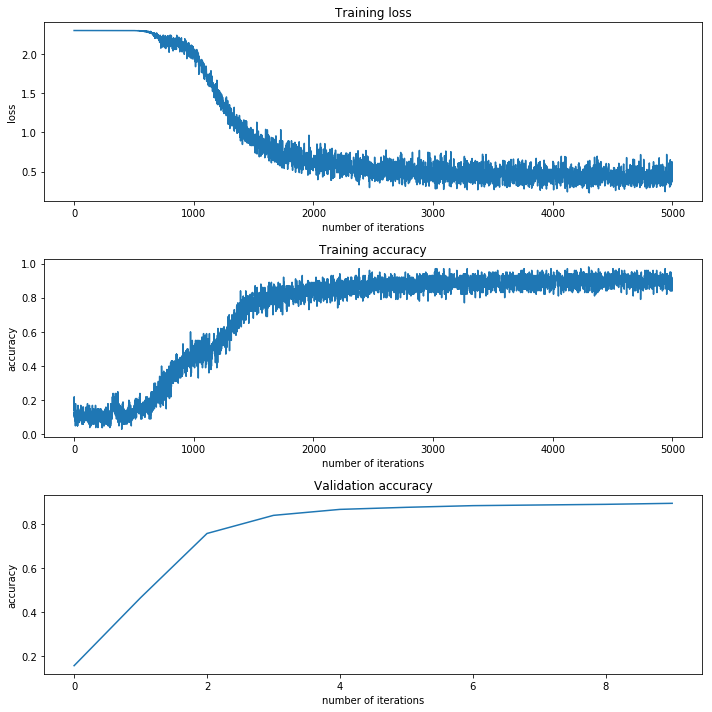

In [6]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
ax[0].plot(hist['loss'])
ax[0].set_title('Training loss') 
ax[0].set_xlabel('number of iterations')
ax[0].set_ylabel('loss')

ax[1].plot(hist['train_acc'])
ax[1].set_title('Training accuracy') 
ax[1].set_xlabel('number of iterations')
ax[1].set_ylabel('accuracy')

ax[2].plot(hist['val_acc'])
ax[2].set_title('Validation accuracy') 
ax[2].set_xlabel('number of iterations')
ax[2].set_ylabel('accuracy')

fig.tight_layout()

## Weights visualization

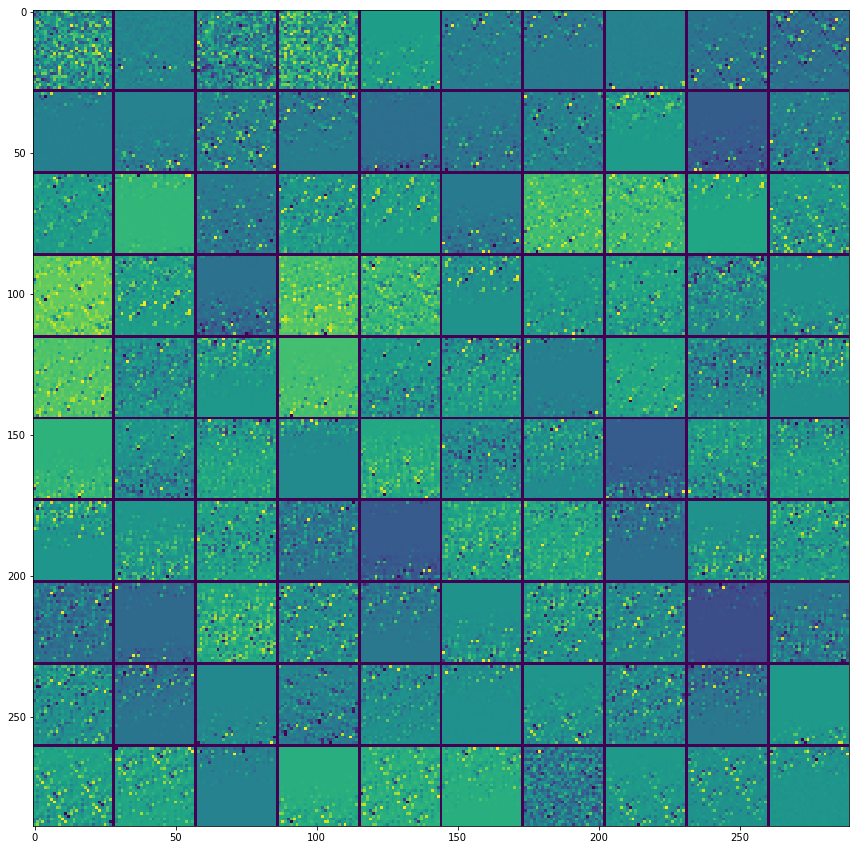

In [12]:
from vis_utils import visualize_grid

W1 = params['W1']
W1 = np.reshape(W1, (-1,28,28))

fig = plt.figure(figsize=(15,15))
plt.imshow(visualize_grid(W1))


## Test evaluation

In [7]:
pred_labels, test_acc = predict_two_layer_perceptron(params, test_data, test_labels)
print('test accuracy:', test_acc)

test accuracy: 0.887
